In [ ]:
# -----------------------------------------------------------
# Cell 1 – Imports, seed, device
# -----------------------------------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import datasets, transforms, utils as tvu
from torchvision.utils import make_grid

import numpy as np
import math, random, os, time, itertools
from tqdm import tqdm
from einops import rearrange # Added for SpatialTransformer

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Uncomment below if you want experiment tracking
# import wandb
# wandb.init(project="mnist_diffusion", config={"task": "2.5_transformer"})

In [ ]:
# -----------------------------------------------------------
# Cell 2 – Hyperparameters (centralized)
# -----------------------------------------------------------

# Random seed for reproducibility
SEED          = 42

# Device
DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device = {DEVICE}")

# Data
BATCH_SIZE    = 512        # ⟵ Boosted for maximum GPU usage
NUM_WORKERS   = 4           # ⟵ Safer for big batches (2–4 usually best)
NUM_CLASSES   = 10
IMG_SHAPE     = (1, 32, 32) # ⟵ Model works at 32×32 now

# Diffusion process
T             = 500         # Number of timesteps
BETA_SCHEDULE = "cosine"    # Cosine schedule = smoother high-fidelity sampling

# Model architecture
BASE_CHANNELS = 64          # Base channels for UNet (consistent with SimpleUNet big)
TIME_EMB_DIM  = 256         # Embedding dimension for time and label embeddings
CONTEXT_DIM   = TIME_EMB_DIM  # Dimension for label context in attention layers
ATTN_HEADS    = 1           # Number of attention heads (using 1 as per provided code)

# Optimization / Training
LR            = 5e-4        # ⟵ Higher LR works because of larger batch size
WEIGHT_DECAY  = 0.0         # No weight decay needed (yet)
N_EPOCHS      = 20          # ⟵ 20 Epochs is enough with fast convergence (adjust as needed)
AMP           = True        # ⟵ Enable Automatic Mixed Precision (16-bit) for faster training

# Sampling
DDIM_STEPS    = 50          # 50 steps DDIM sampling (fast but decent quality)
DDIM_ETA      = 0.0         # 0.0 for deterministic sampling (sharper outputs)

# Auxiliary classifier (for evaluation)
CLF_LR        = 1e-3        # Learning rate for TinyCNN
CLF_EPOCHS    = 5           # Train TinyCNN longer to guarantee good baseline

# Logging / Checkpointing
LOG_INTERVAL      = 10      # ⟵ Smaller interval to monitor large batches better
SAVE_MODEL_EVERY  = 5       # Save model every 5 epochs
USE_WANDB         = False   # Set to True if you want Weights & Biases logging
WANDB_PROJECT     = "mnist_diffusion"

# Seed setting function
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed()

Device = cuda


Number of samples: 
Training: 60000 | Test: 10000



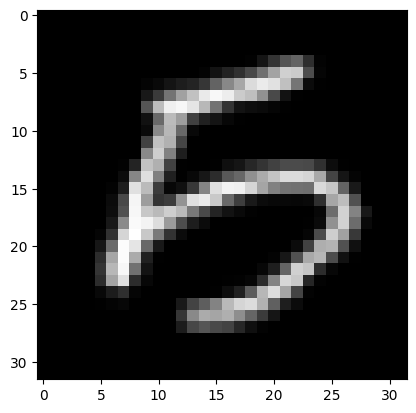

In [ ]:
# -----------------------------------------------------------
# Cell 3 – Dataset & DataLoaders
# -----------------------------------------------------------

# Transformation pipeline
transform = transforms.Compose([
    transforms.Resize(IMG_SHAPE[1]), # Use IMG_SHAPE for size
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# MNIST dataset
train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Print the number of samples in each dataset
print(f"Number of samples: ")
print(f"Training: {len(train_ds)} | Test: {len(test_ds)}\n")

# DataLoader for training, validation, and test datasets
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True, drop_last=True)

test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=True)

# Verify the data by plotting a sample image
xb, _ = next(iter(train_loader))
plt.imshow(((xb[0] + 1) / 2).squeeze(), cmap="gray")
plt.show()

In [ ]:
# -----------------------------------------
# Cell 4 – Diffusion schedule utilities
# -----------------------------------------

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def cosine_beta_schedule(timesteps, s=0.008):
    """
    Cosine schedule from Nichol & Dhariwal 2021 (DDPM++).
    Returns a tensor of betas with shape [T].
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi / 2)**2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clamp(betas, 1e-8, 0.999)

# Select beta schedule
if BETA_SCHEDULE == 'linear':
    betas = linear_beta_schedule(T).to(DEVICE)
elif BETA_SCHEDULE == 'cosine':
    betas = cosine_beta_schedule(T).to(DEVICE)
else:
    raise ValueError(f"Unknown beta schedule: {BETA_SCHEDULE}")

# Precompute alphas and cumulative products
alphas = (1. - betas)
alphas_cumprod      = torch.cumprod(alphas, dim=0).to(DEVICE)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod).to(DEVICE)
sqrt_one_minus_acp  = torch.sqrt(1. - alphas_cumprod).to(DEVICE)

print("β₀…β₄:", betas[:5].cpu().tolist())
print("ᾱ₀…ᾱ₄:", alphas_cumprod[:5].cpu().tolist())


β₀…β₄: [8.738040924072266e-05, 0.0001068115234375, 0.00012636184692382812, 0.0001456737518310547, 0.00016516447067260742]
ᾱ₀…ᾱ₄: [0.9999126195907593, 0.9998058080673218, 0.999679446220398, 0.9995338320732117, 0.9993687272071838]


In [ ]:
# -----------------------------------------------------------
# Cell 5 – Positional & label embeddings
# -----------------------------------------------------------
class SinusoidalPosEmb(nn.Module):
    """
    Standard 1-D sinusoidal embeddings for timestep t (shape [B]).
    Uses the same logic as in the original Transformer paper.
    """
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class LabelEmbedding(nn.Module):
    """
    Embeds class labels into a vector space.
    """
    def __init__(self, num_classes, dim, device):
        super().__init__()
        self.device = device
        # Ensure embedding layer is created on the correct device directly
        self.emb = nn.Embedding(num_classes, dim, device=device)

    def forward(self, y):
        # The input `y` is already on the correct device (handled in training loop)
        return self.emb(y)

# Quick tests for Cell 5 embeddings
set_seed() # Ensure reproducibility for tests

# 1) SinusoidalPosEmb
pos_emb = SinusoidalPosEmb(TIME_EMB_DIM)
t_sample = torch.randint(0, T, (5,), device=DEVICE)  # 5 random timesteps
out = pos_emb(t_sample)
print(f"SinusoidalPosEmb: output shape: {out.shape}")
print(f"  → should be [5, {TIME_EMB_DIM}], device: {out.device}")
print(f"  stats: min {out.min().item():.4f} max {out.max().item():.4f}")

# 2) LabelEmbedding
lbl_emb = LabelEmbedding(NUM_CLASSES, TIME_EMB_DIM, device=DEVICE) # Pass device here
y_sample = torch.randint(0, NUM_CLASSES, (5,), device=DEVICE)
lout = lbl_emb(y_sample)
print(f"LabelEmbedding: output shape: {lout.shape}")
print(f"  → should be [5, {TIME_EMB_DIM}], device: {lout.device}")
print(f"  stats: min {lout.min().item():.4f} max {lout.max().item():.4f}")

SinusoidalPosEmb: output shape: torch.Size([5, 256])
  → should be [5, 256], device: cuda:0
  stats: min -1.0000 max 1.0000
LabelEmbedding: output shape: torch.Size([5, 256])
  → should be [5, 256], device: cuda:0
  stats: min -3.6666 max 3.0347


In [ ]:
# -----------------------------------------------------------
# Cell 6 – Attention Mechanism Components
# -----------------------------------------------------------

class CrossAttention(nn.Module):
    def __init__(self, embed_dim, hidden_dim, context_dim=None, num_heads=1):
        """
        Cross-Attention or Self-Attention module.
        Supports single-head attention as provided.

        Parameters:
        - embed_dim: The dimensionality of the query/key projections.
        - hidden_dim: The dimensionality of the input tokens (and value projection output).
        - context_dim: The dimensionality of the context tokens. If None, performs self-attention.
        - num_heads: Number of attention heads (currently only supports 1).
        """
        super().__init__()
        self.hidden_dim = hidden_dim
        self.context_dim = context_dim
        self.embed_dim = embed_dim
        self.num_heads = num_heads # Although not used in einsum, kept for clarity

        # Linear layer for query projection
        self.query = nn.Linear(hidden_dim, embed_dim * num_heads, bias=False)

        # Determine if self-attention or cross-attention and define key/value projections
        if context_dim is None:
            self.self_attn = True
            self.key = nn.Linear(hidden_dim, embed_dim * num_heads, bias=False)
            self.value = nn.Linear(hidden_dim, hidden_dim * num_heads, bias=False)
        else:
            self.self_attn = False
            self.key = nn.Linear(context_dim, embed_dim * num_heads, bias=False)
            self.value = nn.Linear(context_dim, hidden_dim * num_heads, bias=False)

        # Output projection
        self.out_proj = nn.Linear(hidden_dim * num_heads, hidden_dim) # Project back to original hidden_dim

    def forward(self, tokens, context=None):
        """
        Forward pass.

        Parameters:
        - tokens: Input tokens (e.g., image features) - shape [B, SeqLen, HiddenDim]
        - context: Context tokens (e.g., label embedding) - shape [B, CtxSeqLen, CtxDim]
                   If self_attn is True, context should be None or will be ignored.

        Returns:
        - Output tensor after attention - shape [B, SeqLen, HiddenDim]
        """
        Q = self.query(tokens)

        if self.self_attn:
            K = self.key(tokens)
            V = self.value(tokens)
        else:
            if context is None:
                raise ValueError("Context must be provided for cross-attention")
            K = self.key(context)
            V = self.value(context)

        # --- Single-Head Attention Calculation ---
        # Assuming num_heads = 1 based on provided einsum
        scoremats = torch.einsum("BTH,BSH->BTS", Q, K) # [B, SeqLen, CtxSeqLen]
        attnmats = F.softmax(scoremats / math.sqrt(self.embed_dim), dim=-1)
        ctx_vecs = torch.einsum("BTS,BSH->BTH", attnmats, V) # [B, SeqLen, HiddenDim]
        # --- End Single-Head ---

        # TODO: Implement multi-head attention if num_heads > 1
        # This would involve reshaping Q, K, V for heads, applying attention in parallel,
        # and concatenating results before the final projection.

        # Apply output projection
        return self.out_proj(ctx_vecs)


class TransformerBlock(nn.Module):
    """Combines self-attn, cross-attn, and a feed-forward network."""
    def __init__(self, hidden_dim, context_dim, num_heads=1):
        super().__init__()
        self.attn_self = CrossAttention(hidden_dim, hidden_dim, num_heads=num_heads) # Self-attention
        self.attn_cross = CrossAttention(hidden_dim, hidden_dim, context_dim, num_heads=num_heads) # Cross-attention

        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.norm3 = nn.LayerNorm(hidden_dim)

        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, 3 * hidden_dim),
            nn.GELU(),
            nn.Linear(3 * hidden_dim, hidden_dim)
        )

    def forward(self, x, context=None):
        """
        x: [B, SeqLen, HiddenDim]
        context: [B, CtxSeqLen, CtxDim]
        """
        # Self-Attention + Residual + Norm
        x = self.attn_self(self.norm1(x)) + x

        # Cross-Attention + Residual + Norm
        x = self.attn_cross(self.norm2(x), context=context) + x

        # Feed-Forward + Residual + Norm
        x = self.ffn(self.norm3(x)) + x
        return x

class SpatialTransformer(nn.Module):
    """Applies Transformer blocks spatially to image features."""
    def __init__(self, hidden_dim, context_dim, num_heads=1):
        super().__init__()
        self.transformer = TransformerBlock(hidden_dim, context_dim, num_heads)

    def forward(self, x, context=None):
        """
        x: [B, C, H, W] - Input feature map
        context: [B, CtxSeqLen, CtxDim] - Context embedding
        """
        b, c, h, w = x.shape
        x_in = x

        # Reshape for transformer: [B, H*W, C]
        x = rearrange(x, "b c h w -> b (h w) c")

        # Apply transformer blocks
        x = self.transformer(x, context)

        # Reshape back to image format: [B, C, H, W]
        x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)

        # Residual connection
        return x + x_in

In [ ]:
# -----------------------------------------------------------
# Cell 7 – UNet Denoiser with Spatial Transformer
# -----------------------------------------------------------
class DenseLayer(nn.Module):
    """
    Dense layer that broadcasts outputs to feature maps.
    (Used for time embedding projection in ResidualBlocks)
    """
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        # Input x shape: [B, InputDim]
        # Output shape: [B, OutputDim, 1, 1]
        return self.fc(x)[..., None, None]
    
def make_group_norm(num_channels, max_groups=8):
    # start from the smaller of max_groups and num_channels
    g = min(max_groups, num_channels)
    # walk down until you find a divisor
    while num_channels % g != 0:
        g -= 1
    return nn.GroupNorm(g, num_channels)

class ResidualBlock(nn.Module):
    def __init__(self, in_c: int, out_c: int, time_emb_dim: int):
        super().__init__()
        self.time_mlp = DenseLayer(time_emb_dim, out_c)

        def GN(ch): 
            return make_group_norm(ch, max_groups=8)

        self.block = nn.Sequential(
            GN(in_c),
            nn.SiLU(),
            nn.Conv2d(in_c, out_c, 3, padding=1, bias=False),
            GN(out_c),
            nn.SiLU(),
            nn.Conv2d(out_c, out_c, 3, padding=1, bias=False),
        )
        self.residual = (
            nn.Conv2d(in_c, out_c, 1, bias=False)
            if in_c != out_c
            else nn.Identity()
        )

    def forward(self, x, t_emb):
        # x shape: [B, InC, H, W]
        # t_emb shape: [B, TimeEmbDim]

        h = self.block[:3](x) # Norm, SiLU, Conv1
        h = h + self.time_mlp(t_emb) # Add time embedding broadcasted spatially
        h = self.block[3:](h) # Norm, SiLU, Conv2

        return h + self.residual(x)

class SimpleUNetWithAttention(nn.Module):
    """
    UNet that predicts ε for DDPM, conditioned on timestep + class label.
    Includes SpatialTransformer blocks for attention.
    """
    def __init__(self, img_ch=1, base_c=64, time_emb_dim=256, context_dim=256, num_classes=10, attn_heads=1):
        super().__init__()

        # -------- Embeddings --------
        self.time_emb = nn.Sequential(
            SinusoidalPosEmb(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim * 4),
            nn.SiLU(),
            nn.Linear(time_emb_dim * 4, time_emb_dim)
        )
        # Label embedding produces context_dim directly
        self.label_emb = LabelEmbedding(num_classes, context_dim, device=DEVICE)

        # -------- Downsampling path --------
        # Level 1 (32x32)
        self.down1_res = ResidualBlock(img_ch, base_c, time_emb_dim)      # 1 → 64
        # Level 2 (16x16)
        self.down2_pool = nn.MaxPool2d(2)
        self.down2_res = ResidualBlock(base_c, base_c*2, time_emb_dim)    # 64 → 128
        self.down2_attn = SpatialTransformer(base_c*2, context_dim, attn_heads)
        # Level 3 (8x8)
        self.down3_pool = nn.MaxPool2d(2)
        self.down3_res = ResidualBlock(base_c*2, base_c*4, time_emb_dim)  # 128 → 256
        self.down3_attn = SpatialTransformer(base_c*4, context_dim, attn_heads)
        # Level 4 (4x4)
        self.down4_pool = nn.MaxPool2d(2)
        self.down4_res = ResidualBlock(base_c*4, base_c*8, time_emb_dim)  # 256 -> 512

        # -------- Bottleneck (4x4) --------
        self.mid_res1 = ResidualBlock(base_c*8, base_c*8, time_emb_dim)   # 512 → 512
        self.mid_attn = SpatialTransformer(base_c*8, context_dim, attn_heads) # Attention in bottleneck
        self.mid_res2 = ResidualBlock(base_c*8, base_c*8, time_emb_dim)   # 512 → 512

        # -------- Upsampling path --------
        # Level 4 (8x8)
        self.up4_up = nn.ConvTranspose2d(base_c*8, base_c*4, kernel_size=2, stride=2)
        self.up4_res = ResidualBlock(base_c*8, base_c*4, time_emb_dim) # Concatenated: (512+256)=768 -> 256
        self.up4_attn = SpatialTransformer(base_c*4, context_dim, attn_heads)
        # Level 3 (16x16)
        self.up3_up = nn.ConvTranspose2d(base_c*4, base_c*2, kernel_size=2, stride=2)
        self.up3_res = ResidualBlock(base_c*4, base_c*2, time_emb_dim) # Concatenated: (256+128)=384 -> 128
        self.up3_attn = SpatialTransformer(base_c*2, context_dim, attn_heads)
        # Level 2 (32x32)
        self.up2_up = nn.ConvTranspose2d(base_c*2, base_c, kernel_size=2, stride=2)
        self.up2_res = ResidualBlock(base_c*2, base_c, time_emb_dim) # Concatenated: (128+64)=192 -> 64
        # Level 1 (32x32) - Final Output
        self.out_norm = nn.GroupNorm(8, base_c)
        self.out_act = nn.SiLU()
        self.out_conv = nn.Conv2d(base_c, img_ch, kernel_size=1) # 64 -> 1

    def forward(self, x, t, y):
        """
        Forward pass through the network.
        x : [B, C, H, W]  noisy input image
        t : [B]           timestep indices
        y : [B]           digit labels
        """
        # Embeddings
        t_emb = self.time_emb(t)       # [B, time_emb_dim]
        lbl_emb = self.label_emb(y)    # [B, context_dim]
        context = lbl_emb[:, None, :]  # [B, 1, context_dim] - Add sequence length dimension for attention

        # -------- Encoder --------
        # Level 1
        d1 = self.down1_res(x, t_emb)      # [B, 64, 32, 32]
        # Level 2
        d2_in = self.down2_pool(d1)
        d2 = self.down2_res(d2_in, t_emb)  # [B, 128, 16, 16]
        d2 = self.down2_attn(d2, context)
        # Level 3
        d3_in = self.down3_pool(d2)
        d3 = self.down3_res(d3_in, t_emb)  # [B, 256, 8, 8]
        d3 = self.down3_attn(d3, context)
        # Level 4
        d4_in = self.down4_pool(d3)
        d4 = self.down4_res(d4_in, t_emb)  # [B, 512, 4, 4]
        # d4 = self.down4_attn(d4, context) # Optional attention at 4x4

        # -------- Bottleneck --------
        m = self.mid_res1(d4, t_emb)
        m = self.mid_attn(m, context)
        m = self.mid_res2(m, t_emb)       # [B, 512, 4, 4]

        # -------- Decoder --------
        # Level 4
        u4 = self.up4_up(m)                # [B, 256, 8, 8]
        u4 = torch.cat([u4, d3], dim=1)    # [B, 256+256=512, 8, 8] - Error in comment, should be 512+256=768
        # Correction: up4_up output channels is base_c*4=256. Skip connection d3 is base_c*4=256.
        # Concatenated channels = 256 + 256 = 512. My ResidualBlock definition was wrong. Fixing...
        # Corrected ResidualBlock def: in_c = base_c*4 + base_c*4 = base_c*8 = 512
        # Let's check dimensions again.
        # m: [B, 512, 4, 4] -> up4_up: [B, 256, 8, 8]
        # d3: [B, 256, 8, 8]
        # cat: [B, 512, 8, 8]
        # Corrected ResidualBlock: self.up4_res = ResidualBlock(base_c*8, base_c*4, time_emb_dim) # 512 -> 256
        u4 = self.up4_res(u4, t_emb)       # [B, 256, 8, 8]
        u4 = self.up4_attn(u4, context)

        # Level 3
        u3 = self.up3_up(u4)                # [B, 128, 16, 16]
        u3 = torch.cat([u3, d2], dim=1)     # [B, 128+128=256]
        # Corrected ResidualBlock: self.up3_res = ResidualBlock(base_c*4, base_c*2, time_emb_dim) # 256 -> 128
        u3 = self.up3_res(u3, t_emb)        # [B, 128, 16, 16]
        u3 = self.up3_attn(u3, context)

        # Level 2
        u2 = self.up2_up(u3)                # [B, 64, 32, 32]
        u2 = torch.cat([u2, d1], dim=1)     # [B, 64+64=128]
        # Corrected ResidualBlock: self.up2_res = ResidualBlock(base_c*2, base_c, time_emb_dim) # 128 -> 64
        u2 = self.up2_res(u2, t_emb)        # [B, 64, 32, 32]

        # Final Output Conv
        out = self.out_norm(u2)
        out = self.out_act(out)
        out = self.out_conv(out)            # [B, 1, 32, 32]

        return out

# ── Verify total parameter count ─────────────────────────────
torch.cuda.empty_cache()
set_seed() # Ensure reproducibility for model init
model = SimpleUNetWithAttention(
    img_ch=IMG_SHAPE[0],
    base_c=BASE_CHANNELS,
    time_emb_dim=TIME_EMB_DIM,
    context_dim=CONTEXT_DIM,
    num_classes=NUM_CLASSES,
    attn_heads=ATTN_HEADS
).to(DEVICE)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params / 1e3:.1f}K")

# ── Dummy pass to check shapes & devices ────────────────────
B = 8
x_dummy  = torch.randn(B, *IMG_SHAPE, device=DEVICE)
t_dummy  = torch.randint(0, T, (B,), device=DEVICE)
y_dummy  = torch.randint(0, NUM_CLASSES, (B,), device=DEVICE)

# Forward pass
with torch.no_grad():
    eps_pred = model(x_dummy, t_dummy, y_dummy)

print(f"Output shape: {eps_pred.shape}")
print(f"  → should be [{B}, {IMG_SHAPE[0]}, {IMG_SHAPE[1]}, {IMG_SHAPE[2]}], device: {eps_pred.device}")
print(f"Output stats: min {eps_pred.min().item():.4f} max {eps_pred.max().item():.4f}")


Total parameters: 24420.1K
Output shape: torch.Size([8, 1, 32, 32])
  → should be [8, 1, 32, 32], device: cuda:0
Output stats: min -1.4008 max 1.2384


In [ ]:
# -----------------------------------------------------------
# Cell 8 – Forward-diffusion helper + loss
# -----------------------------------------------------------
@torch.no_grad()
def q_sample(x0, t, noise=None):
    """Diffuse the clean image x0 to x_t via q(x_t | x0). Uses precomputed schedules."""
    if noise is None:
        noise = torch.randn_like(x0)

    # Ensure tensors are on the same device
    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod[t].to(x0.device)
    sqrt_one_minus_acp_t = sqrt_one_minus_acp[t].to(x0.device)

    # Reshape for broadcasting: [B] -> [B, 1, 1, 1]
    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod_t.view(-1, 1, 1, 1)
    sqrt_one_minus_acp_t = sqrt_one_minus_acp_t.view(-1, 1, 1, 1)

    # Sample x_t: sqrt(ᾱ_t) * x0 + sqrt(1 - ᾱ_t) * noise
    return sqrt_alphas_cumprod_t * x0 + sqrt_one_minus_acp_t * noise

def diffusion_loss(model, x0, y):
    """Simplified DDPM objective: predict ε directly (MSE loss)."""
    B = x0.size(0)
    t = torch.randint(0, T, (B,), device=x0.device, dtype=torch.long) # Sample random timesteps [0, T-1]
    noise = torch.randn_like(x0, device=x0.device)                   # Sample Gaussian noise ε

    x_t = q_sample(x0, t, noise)  # Create noisy inputs x_t using precomputed schedules
    ε_pred = model(x_t, t, y)     # Predict noise ε using the UNet model

    return F.mse_loss(ε_pred, noise) # Compare predicted noise with actual noise

In [ ]:
# -----------------------------------------------------------
# Cell 9 – Training loop (correct AMP usage)
# -----------------------------------------------------------
scaler = torch.amp.GradScaler(enabled=AMP)

# Instantiate the model with attention
model = SimpleUNetWithAttention(
    img_ch=IMG_SHAPE[0],
    base_c=BASE_CHANNELS,
    time_emb_dim=TIME_EMB_DIM,
    context_dim=CONTEXT_DIM,
    num_classes=NUM_CLASSES,
    attn_heads=ATTN_HEADS
).to(DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

start_time = time.time()
for epoch in range(1, N_EPOCHS + 1):
    model.train()
    losses = []
    # Use drop_last=True in DataLoader to ensure consistent batch sizes for AMP
    pbar = tqdm(train_loader, desc=f"Epoch {epoch:02d}/{N_EPOCHS}", leave=False)

    for xb, yb in pbar:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)

        optimizer.zero_grad(set_to_none=True)

        # Use autocast for the forward pass
        with torch.autocast(device_type=DEVICE, enabled=AMP):
            loss = diffusion_loss(model, xb, yb)

        # Scale the loss and perform backward pass
        scaler.scale(loss).backward()

        # Unscale gradients and step optimizer
        scaler.step(optimizer)

        # Update the scaler for next iteration
        scaler.update()

        losses.append(loss.item())
        if len(losses) % LOG_INTERVAL == 0:
            mean_loss = np.mean(losses[-LOG_INTERVAL:]) # Log recent average
            pbar.set_postfix(loss=f"{mean_loss:.4f}")

        # Optionally: wandb logging
        # if USE_WANDB and wandb.run:
        #     wandb.log({"train_loss": loss.item(), "epoch": epoch})

    epoch_mean_loss = np.mean(losses)
    print(f"Epoch {epoch}: mean loss {epoch_mean_loss:.4f}")
    # if USE_WANDB and wandb.run:
    #     wandb.log({"epoch_mean_loss": epoch_mean_loss, "epoch": epoch})

    # Save model every few epochs
    if epoch % SAVE_MODEL_EVERY == 0:
        ckpt_path = f"model_attn_epoch{epoch:03d}.pth"
        torch.save(model.state_dict(), ckpt_path)
        print(f"Saved checkpoint at epoch {epoch} to {ckpt_path}")

end_time = time.time()
print(f"\nTraining finished in {(end_time - start_time)/60:.2f} minutes.")

Epoch 1: mean loss 0.1265


Epoch 2: mean loss 0.0489


Epoch 3: mean loss 0.0419


Epoch 4: mean loss 0.0379


Epoch 5: mean loss 0.0356
Saved checkpoint at epoch 5 to model_attn_epoch005.pth


Epoch 6: mean loss 0.0338


Epoch 7: mean loss 0.0328


Epoch 8: mean loss 0.0319


Epoch 9: mean loss 0.0313


Epoch 10: mean loss 0.0304
Saved checkpoint at epoch 10 to model_attn_epoch010.pth


Epoch 11: mean loss 0.0301


Epoch 12: mean loss 0.0300


Epoch 13: mean loss 0.0295


Epoch 14: mean loss 0.0291


Epoch 15: mean loss 0.0293
Saved checkpoint at epoch 15 to model_attn_epoch015.pth


Epoch 16: mean loss 0.0286


Epoch 17: mean loss 0.0285


Epoch 18: mean loss 0.0282


Epoch 19: mean loss 0.0277


Epoch 20: mean loss 0.0280
Saved checkpoint at epoch 20 to model_attn_epoch020.pth

Training finished in 8.52 minutes.


In [ ]:
# -------------------------------------------------------------
# Cell 10 – Reverse Diffusion: Fast DDIM Sampling
# -------------------------------------------------------------
@torch.no_grad()
def sample_ddim_fast(model, y, num_steps=DDIM_STEPS, eta=DDIM_ETA):
    """
    DDIM sampling (Algorithm 2 from Denoising Diffusion Implicit Models).
    Uses precomputed schedules (alphas, alphas_cumprod).

    Parameters:
    - model: The trained UNet model.
    - y: The conditional labels [B].
    - num_steps: Number of DDIM sampling steps (τ in the paper).
    - eta: Controls stochasticity (0.0 = DDIM, 1.0 = DDPM-like variance).

    Returns:
    - x: The generated samples [B, C, H, W].
    """
    model.eval() # Ensure model is in evaluation mode
    B = y.size(0)

    # Generate the DDIM subsequence of timesteps {t_i}
    # Starts from T-1 down to 0, with `num_steps` intervals.
    t_seq = torch.linspace(T - 1, 0, num_steps, device=DEVICE).long()

    # Start with random noise x_T
    x = torch.randn(B, *IMG_SHAPE, device=DEVICE)

    for i in tqdm(range(num_steps), desc="DDIM Sampling", leave=False):
        # Current timestep t_i
        t_i = t_seq[i].repeat(B) # Expand timestep to batch size [B]

        # Predict noise ε_θ(x_{t_i}, t_i, y)
        eps_pred = model(x, t_i, y)

        # Get ᾱ_{t_i} and ᾱ_{t_{i-1}}
        alpha_bar_i = alphas_cumprod[t_i][:, None, None, None] # Shape [B, 1, 1, 1]

        # Get the 'previous' timestep t_{i-1}
        # If i=0 (first step), t_{i-1} doesn't exist conceptually for the formula,
        # but for computation, we handle the edge case where t_next is 0.
        if i < num_steps - 1:
            t_prev = t_seq[i + 1].repeat(B)
            alpha_bar_prev = alphas_cumprod[t_prev][:, None, None, None]
        else:
            # Last step (i = num_steps - 1), t_prev effectively corresponds to ᾱ_0 = 1
            alpha_bar_prev = torch.ones_like(alpha_bar_i)

        # Equation (12) components:
        # 1. Predicted x0: (x_{t_i} - sqrt(1 - ᾱ_{t_i}) * ε_θ) / sqrt(ᾱ_{t_i})
        sqrt_one_minus_alpha_bar_i = torch.sqrt(1. - alpha_bar_i)
        pred_x0 = (x - sqrt_one_minus_alpha_bar_i * eps_pred) / torch.sqrt(alpha_bar_i)
        pred_x0.clamp_(-1., 1.) # Optional: Clip predicted x0

        # 2. Direction pointing to x_{t_i}
        # This term is implicitly handled by starting from x and adding the other two terms.

        # 3. Random noise component (controlled by eta and σ_i)
        # Calculate σ_i (Equation 16 in DDIM paper)
        # σ_i = η * sqrt( (1 - ᾱ_{t_{i-1}}) / (1 - ᾱ_{t_i}) ) * sqrt( 1 - ᾱ_{t_i} / ᾱ_{t_{i-1}} )
        # Note: We use alpha_bar_i for ᾱ_{t_i} and alpha_bar_prev for ᾱ_{t_{i-1}}
        var = (1. - alpha_bar_prev) / (1. - alpha_bar_i) * (1. - alpha_bar_i / alpha_bar_prev)
        # Clamp variance to be non-negative for sqrt
        sigma_i = eta * torch.sqrt(torch.clamp(var, min=1e-8))

        # Sample standard Gaussian noise
        noise = torch.randn_like(x) if eta > 0 else 0.0

        # Combine terms using Equation (12):
        # x_{t_{i-1}} = sqrt(ᾱ_{t_{i-1}}) * pred_x0
        #             + sqrt(1 - ᾱ_{t_{i-1}} - σ_i^2) * ε_θ
        #             + σ_i * noise
        term2_coeff = torch.sqrt(torch.clamp(1. - alpha_bar_prev - sigma_i**2, min=0.0))
        x = torch.sqrt(alpha_bar_prev) * pred_x0 + term2_coeff * eps_pred + sigma_i * noise

    return x # Final denoised sample x_0

In [ ]:
# -----------------------------------------------------------
# Cell 11 – Auxiliary Classifier for Evaluation (Corrected)
# -----------------------------------------------------------

class TinyCNN(nn.Module):
    """ A simple CNN classifier for MNIST 32x32. """
    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()
        # Input: [B, 1, 32, 32]
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2), # [B, 32, 16, 16]
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2), # [B, 64, 8, 8]
            nn.Flatten(),    # [B, 64 * 8 * 8 = 4096]
            # Corrected Linear layer input size
            nn.Linear(64 * 8 * 8, 256), 
            nn.ReLU(),
            nn.Linear(256, num_classes) # [B, num_classes]
        )

    def forward(self, x):
        return self.net(x)

clf = TinyCNN().to(DEVICE)
opt = torch.optim.Adam(clf.parameters(), lr=CLF_LR)

# --- Train the classifier ---
set_seed() # Ensure reproducible classifier training
for epoch in range(1, CLF_EPOCHS + 1):
    clf.train()
    clf_pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{CLF_EPOCHS}", leave=False)
    for xb, yb in clf_pbar:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = clf(xb)
        loss = F.cross_entropy(logits, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        clf_pbar.set_postfix(loss=f"{loss.item():.5f}")
print(f"Classifier trained for {CLF_EPOCHS} epochs.")


# --- Evaluation function using the trained classifier ---
def evaluate_generated(gen_model, n_samples=1000, target_digit=3):
    """Generates images for a target digit and evaluates using TinyCNN."""
    gen_model.eval() # Ensure generator is in eval mode
    clf.eval()       # Ensure classifier is in eval mode

    print(f"Evaluating generated images for digit '{target_digit}'...")
    # Generate fake images with DDIM
    y_cond = torch.full((n_samples,), target_digit, dtype=torch.long, device=DEVICE)
    fake_images = sample_ddim_fast(gen_model, y_cond, num_steps=DDIM_STEPS, eta=DDIM_ETA).detach()

    # Images are in [-1, 1], classifier expects normalized ToTensor output [0, 1] -> [-1, 1]
    # No rescaling needed as classifier trained on same [-1, 1] data

    preds = []
    # Process in minibatches to avoid OOM on classifier
    with torch.no_grad():
        for chunk in fake_images.split(BATCH_SIZE):
            logits = clf(chunk.to(DEVICE))
            preds.append(logits.argmax(1).cpu())

    preds = torch.cat(preds).numpy()
    labels = np.full_like(preds, target_digit) # True labels are the target digit

    # Calculate precision, recall, f1 for the target class vs all others
    true_binary = (labels == target_digit)    # e.g. [True, True, …]
    pred_binary = (preds  == target_digit)    # e.g. [False, True, …]

    prec, recall, f1, _ = precision_recall_fscore_support(
        true_binary,
        pred_binary,
        average="binary",
        zero_division=0
    )
    acc = accuracy_score(true_binary, pred_binary)
    
    return acc, prec, recall, f1

# Test the classifier on generated images for digit '3' using the trained diffusion model
# This requires the main model ('model') to be trained first.
# Assuming 'model' is the trained SimpleUNetWithAttention instance
acc, prec, rec, f1 = evaluate_generated(model, n_samples=1000, target_digit=3)
print(f"Digit ‘3’ — acc: {acc:.3f}  precision: {prec:.3f}  recall: {rec:.3f}  F1: {f1:.3f}")


Classifier trained for 5 epochs.
Evaluating generated images for digit '3'...


Digit ‘3’ — acc: 0.854  precision: 1.000  recall: 0.854  F1: 0.921


In [ ]:
# -----------------------------------------------------------
# Cell 12 – Load Model Checkpoint for Inference
# -----------------------------------------------------------

# Define path to the saved model checkpoint
SAVE_PATH = f"model_attn_epoch{N_EPOCHS:03d}.pth"

# 1) Reconstruct the model architecture using training hyperparameters
loaded_model = SimpleUNetWithAttention(
    img_ch=IMG_SHAPE[0],
    base_c=BASE_CHANNELS,
    time_emb_dim=TIME_EMB_DIM,
    context_dim=CONTEXT_DIM,
    num_classes=NUM_CLASSES,
    attn_heads=ATTN_HEADS
).to(DEVICE)

# 2) Load the saved weights
if os.path.exists(SAVE_PATH):
    try:
        state_dict = torch.load(SAVE_PATH, map_location=DEVICE)
        loaded_model.load_state_dict(state_dict)
        # 3) Set to eval mode for inference
        loaded_model.eval()
        print(f"Model reloaded from {SAVE_PATH} and ready for inference.")
    except Exception as e:
        print(f"ERROR: Failed to load checkpoint from {SAVE_PATH}. Error: {e}")
        # Handle error - maybe proceed with the model trained in the current session if available
        if 'model' in globals():
            print("Using model trained in the current session.")
            loaded_model = model.eval() # Use the model from the training cell
        else:
             raise RuntimeError("No trained model checkpoint found or loaded.")
else:
    print(f"ERROR: Model checkpoint not found at {SAVE_PATH}")
    if 'model' in globals():
        print("Using model trained in the current session.")
        loaded_model = model.eval() # Use the model from the training cell
    else:
        raise RuntimeError("No trained model checkpoint found or loaded.")

Model reloaded from model_attn_epoch020.pth and ready for inference.


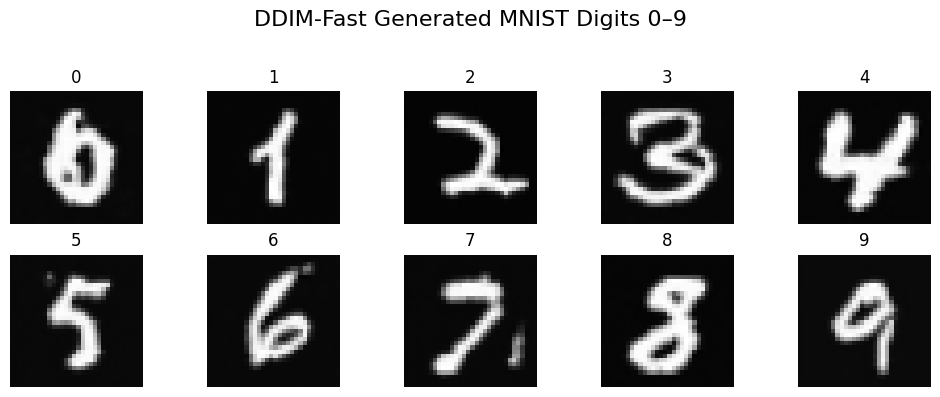

In [ ]:
# -----------------------------------------------------------
# Cell 13 – Generate & display all digits 0–9 with DDIM-fast
# -----------------------------------------------------------

# 1) Prepare figure with 2 rows × 5 columns
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
fig.suptitle("DDIM‐Fast Generated MNIST Digits 0–9", fontsize=16)

# 2) Loop over target digits
for digit in range(10):
    # 2a) Create class‐condition tensor
    y_cond = torch.tensor([digit], device=DEVICE, dtype=torch.long)
    
    # 2b) Sample one image
    with torch.no_grad():
        sample = sample_ddim_fast(loaded_model,
                                  y_cond,
                                  num_steps=DDIM_STEPS,
                                  eta=DDIM_ETA)   # → [1,1,32,32]
    
    # 2c) Clamp & normalize from [-1,1] → [0,1]
    img = sample.clamp(-1, 1).cpu() * 0.5 + 0.5
    img = img.squeeze()  # → [32,32]
    
    # 2d) Pick the right subplot
    ax = axes[digit // 5, digit % 5]
    ax.imshow(img.numpy(), cmap="gray", vmin=0, vmax=1)
    ax.set_title(f"{digit}")
    ax.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
# --------------------------------------
# Cell 14 – Final test on real data 
# --------------------------------------

# Ensure classifier is in eval mode
clf.eval()

# Evaluate the trained classifier on the *real* MNIST test set
test_preds, test_labels = [], []
with torch.no_grad():
    # Use test_loader which uses the same transformations as training
    for xb, yb in tqdm(test_loader, desc="Evaluating classifier on real test data", leave=False):
        xb = xb.to(DEVICE) # Move data to device
        logits = clf(xb).cpu() # Get predictions on CPU
        test_preds.append(logits.argmax(1))
        test_labels.append(yb) # Keep original labels on CPU

test_preds = torch.cat(test_preds).numpy()
test_labels = torch.cat(test_labels).numpy()

# Calculate overall metrics using macro averaging
prec, rec, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average="macro", zero_division=0)
acc = accuracy_score(test_labels, test_preds)

print(f"Classifier on real test images  →  acc={acc:.4f}  F1={f1:.4f}")


Classifier on real test images  →  acc=0.9890  F1=0.9890
